In [4]:
import kinase_library as kl
import numpy as np
import pandas as pd

In [5]:
prot_info = pd.read_json('../data/phosphosite_sequences/phosphosite_df.json')
prot_info

,id,sites,sequence
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...
2,A0A087WP46,"[359, 972, 973, 974, 988, 997, 1000, 1005, 101...",MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...
3,A0A087WPF7,"[32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...",MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...
...,...,...,...
42252,XP_997087,"[347, 907, 915, 918, 927]",MENFLALMNSISDTWMSPSCMDIAMDMGIAFVCGAGLFFLLLPFLK...
42253,YP_009725299,"[504, 660, 661, 794, 1826]",APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...


In [6]:
kinase_info = pd.read_csv('../data/kinase_library/kinome_information.tsv', sep='\t')
kinase_info

,MATRIX_NAME,KINASE,GENE_NAME,TYPE,SUBTYPE,FAMILY,UNIPROT_ID,UNIPROT_ENTRY_NAME,PDB_ID,KL_LIBRARY,DUAL_SPECIFICITY,DISPLAY_NAME
0,AAK1,AAK1,AAK1,ser_thr,STK,Other,Q2M2I8,AAK1_HUMAN,4WSQ,ser_thr,False,AAK1
1,ACVR2A,ACVR2A,ACVR2A,ser_thr,STK,TKL,P27037,AVR2A_HUMAN,3Q4T,ser_thr,False,ACVR2A
2,ACVR2B,ACVR2B,ACVR2B,ser_thr,STK,TKL,Q13705,AVR2B_HUMAN,2H62,ser_thr,False,ACVR2B
3,AKT1,AKT1,AKT1,ser_thr,STK,AGC,P31749,AKT1_HUMAN,1H10,ser_thr,False,AKT1
4,AKT2,AKT2,AKT2,ser_thr,STK,AGC,P31751,AKT2_HUMAN,1GZK,ser_thr,False,AKT2
...,...,...,...,...,...,...,...,...,...,...,...,...
398,VEGFR2,VEGFR2,KDR,tyrosine,RTK,VEGFR,P35968,VGFR2_HUMAN,1VR2,tyr,False,VEGFR2
399,VEGFR3,VEGFR3,FLT4,tyrosine,RTK,VEGFR,P35916,VGFR3_HUMAN,4BSJ,tyr,False,VEGFR3
400,WEE1_TYR,WEE1,WEE1,tyrosine,ncTK,WEE,P30291,WEE1_HUMAN,1X8B,ser_thr_tyr,False,WEE1 (Tyr)
401,YES,YES,YES1,tyrosine,nRTK,SRC,P07947,YES_HUMAN,2HDA,tyr,False,YES


In [7]:
kinase_info=kinase_info.set_index('MATRIX_NAME')

In [6]:
kinase_info

,KINASE,GENE_NAME,TYPE,SUBTYPE,FAMILY,UNIPROT_ID,UNIPROT_ENTRY_NAME,PDB_ID,KL_LIBRARY,DUAL_SPECIFICITY,DISPLAY_NAME
MATRIX_NAME,,,,,,,,,,,
AAK1,AAK1,AAK1,ser_thr,STK,Other,Q2M2I8,AAK1_HUMAN,4WSQ,ser_thr,False,AAK1
ACVR2A,ACVR2A,ACVR2A,ser_thr,STK,TKL,P27037,AVR2A_HUMAN,3Q4T,ser_thr,False,ACVR2A
ACVR2B,ACVR2B,ACVR2B,ser_thr,STK,TKL,Q13705,AVR2B_HUMAN,2H62,ser_thr,False,ACVR2B
AKT1,AKT1,AKT1,ser_thr,STK,AGC,P31749,AKT1_HUMAN,1H10,ser_thr,False,AKT1
AKT2,AKT2,AKT2,ser_thr,STK,AGC,P31751,AKT2_HUMAN,1GZK,ser_thr,False,AKT2
...,...,...,...,...,...,...,...,...,...,...,...
VEGFR2,VEGFR2,KDR,tyrosine,RTK,VEGFR,P35968,VGFR2_HUMAN,1VR2,tyr,False,VEGFR2
VEGFR3,VEGFR3,FLT4,tyrosine,RTK,VEGFR,P35916,VGFR3_HUMAN,4BSJ,tyr,False,VEGFR3
WEE1_TYR,WEE1,WEE1,tyrosine,ncTK,WEE,P30291,WEE1_HUMAN,1X8B,ser_thr_tyr,False,WEE1 (Tyr)


In [7]:
def mark_fn(row):
    buf = []
    print(row['id'])
    split_seq = list(row['sequence'])
    for i in row['sites']:
        idx = eval(i) - 1 # 1-based indices in sites
        split_seq[idx] = str.lower(split_seq[idx])
    
    win_size = 6
    for i in row['sites']:
        idx = eval(i) - 1
        if split_seq[idx] not in ['s', 't', 'y']:
            continue
        left = idx - win_size
        left_pad = []
        while left < 0:
            left_pad.append('_')
            left += 1

        right = idx + win_size + 1
        right_pad = []
        while right > len(split_seq):
            right_pad.append('_')
            right -= 1
        window = split_seq[left:right]
        window = left_pad + window + right_pad
        #window[win_size] = window[win_size] + '*'
        buf.append("".join(window))

    preds = {
        'Name' : [],
        'Family' : [],
        'Score' : [],
        'Score Rank' : [],
        'Percentile' : [],
        'Percentile Rank' : []
    }
    for window in buf:
        sub = kl.Substrate(window, pp=True) # using phosphopriming
        
        prediction = sub.predict().reset_index(names='Name').iloc[0].to_dict()
        preds['Family'].append(kinase_info.loc[prediction['Name']]['FAMILY'])
        for k, v in prediction.items():
            preds[k].append(v)

    return preds

In [ ]:
prot_info[prot_info['id'] == 'A6NK53']

,id,sites,sequence
795,A6NK53,"[18, 33, 100, 342, 347, 447, 475, 503, 531, 55...",MTKFQEMVTFKDVAVVFTREELGLLDLAQRKLYQDVMLENFRNLLS...


In [ ]:
mark_fn(prot_info.loc[795])

A6NK53
DVAVVFtREELGL
LAQRKLyQDVMLE
RLRFLSyEDLICW
STGENLyRCQVyA
LyRCQVyARSSNQ
LHQRVHtGEKPYK
AHQRIHtGEKPYK
AHQRVHtGEKPYK
DHQQVHtGENPYK
AHQRVHtGEKPYK
VHQRIHtGEKPYK
AHQRVHtGEKPYK
GKGFSKsSLSSDs
sSLSSDsSESP__


{'Name': ['TSSK2',
  'EPHA1',
  'EPHA4',
  'BRK',
  'ITK',
  'PBK',
  'PBK',
  'PBK',
  'GAK',
  'PBK',
  'PBK',
  'PBK',
  'ULK1',
  'FAM20C'],
 'Family': ['CAMK',
  'EPHR',
  'EPHR',
  'FRK',
  'TEC',
  'Other',
  'Other',
  'Other',
  'Other',
  'Other',
  'Other',
  'Other',
  'Other',
  'FAM20'],
 'Score': [2.0956,
  2.8045,
  2.8682,
  1.8786,
  3.2274,
  6.664,
  7.132,
  6.664,
  2.673,
  6.664,
  7.132,
  6.664,
  1.044,
  3.8064],
 'Score Rank': [1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 10, 1],
 'Percentile': [95.82,
  97.92,
  95.99,
  96.23,
  98.25,
  99.93,
  99.97,
  99.93,
  99.71,
  99.93,
  99.97,
  99.93,
  98.34,
  96.46],
 'Percentile Rank': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
test_preds = prot_info[:5].apply(mark_fn, axis=1)

In [ ]:
test_df = prot_info[:5]

In [ ]:
test_df['kinase_preds'] = test_preds
test_df

C:\Users\Samo\AppData\Local\Temp\ipykernel_12660\2655177893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['kinase_preds'] = test_preds


,id,sites,sequence,kinase_preds
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,"{'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [..."
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,"{'Name': ['MAPKAPK5', 'FGR', 'BIKE', 'ALPHAK3'..."
2,A0A087WP46,"[359, 972, 973, 974, 988, 997, 1000, 1005, 101...",MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...,"{'Name': ['PRP4', 'YANK3', 'FAK', 'PRPK', 'BUB..."
3,A0A087WPF7,"[32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...",MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,"{'Name': ['LKB1', 'HASPIN', 'GSK3B', 'NEK11', ..."
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,"{'Name': ['PDGFRA'], 'Family': ['PDGFR'], 'Sco..."


In [ ]:
test_df.to_json('ki_test.json')

In [11]:
pd.read_json('ki_test.json')

,id,sites,sequence,kinase_preds
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,"{'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [..."
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,"{'Name': ['MAPKAPK5', 'FGR', 'BIKE', 'ALPHAK3'..."
2,A0A087WP46,"[359, 972, 973, 974, 988, 997, 1000, 1005, 101...",MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...,"{'Name': ['PRP4', 'YANK3', 'FAK', 'PRPK', 'BUB..."
3,A0A087WPF7,"[32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...",MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,"{'Name': ['LKB1', 'HASPIN', 'GSK3B', 'NEK11', ..."
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,"{'Name': ['PDGFRA'], 'Family': ['PDGFR'], 'Sco..."


In [ ]:
preds = prot_info.apply(mark_fn, axis=1) 

A0A024R4G9
A0A075B759
A0A087WP46
A0A087WPF7
A0A087WQ53
A0A087WQ89
A0A087WQP5
A0A087WR82
A0A087WUL8
A0A096LNH2
A0A096LP49
A0A096LP55
A0A096MIZ1
A0A096MJJ4
A0A096MJN4
A0A096MJT6
A0A096MK47
A0A096MKA8
A0A0A0MQ87
A0A0A6YY25
A0A0B4J1F3
A0A0B4J1G0
A0A0B4J1L0
A0A0B4J1M2
A0A0B4J2A2
A0A0B4J2F2
A0A0C4DFX5
A0A0G2JEB6
A0A0G2JFH2
A0A0G2JFH3
A0A0G2JTM7
A0A0G2JTR4
A0A0G2JTZ2
A0A0G2JUA5
A0A0G2JUG7
A0A0G2JV04
A0A0G2JV12
A0A0G2JVL5
A0A0G2JVZ7
A0A0G2JWA8
A0A0G2JXN2
A0A0G2JY22
A0A0G2JZ71
A0A0G2JZA1
A0A0G2K094
A0A0G2K0D3
A0A0G2K1J3
A0A0G2K1Q8
A0A0G2K344
A0A0G2K369
A0A0G2K3F3
A0A0G2K472
A0A0G2K475
A0A0G2K543
A0A0G2K715
A0A0G2K719
A0A0G2K744
A0A0G2K7U7
A0A0G2K8N1
A0A0G2K9M5
A0A0G2KA14
A0A0G2QC33
A0A0J9YU71
A0A0J9YUW3
A0A0J9YVE4
A0A0J9YWL9
A0A0M3U1B0
A0A0R4J0D1
A0A0U1RPR8
A0A0U1RQK7
A0A0U1RR07
A0A140LIF8
A0A1B0GTR3
A0A1D5RMD1
A0A1W2P872
A0A1W2P884
A0A286YCX6
A0A286YDN9
A0A2U3TZ82
A0A338P6K9
A0A338P6N4
A0A494BA31
A0A494BBH0
A0A571BF63
A0A5F8MPU3
A0A5F9ZHR4
A0A8I5ZXP5
A0A8I6AI80
A0A8I6AVA8
A0A8I6AXR8
A0A8I6GE08

In [ ]:
chunk_size = 500
pred_chunks = []
for i in range(0, prot_info.shape[0] // chunk_size + 1):
    chunk = prot_info.iloc[i * chunk_size : (i + 1) * chunk_size]
    results = chunk.apply(mark_fn, axis=1)
    results.to_json(f'kinase_pred_chunk_{i}.json')


A0A024R4G9
A0A075B759
A0A087WP46
A0A087WPF7
A0A087WQ53
A0A087WQ89
A0A087WQP5
A0A087WR82
A0A087WUL8
A0A096LNH2
A0A096LP49
A0A096LP55
A0A096MIZ1
A0A096MJJ4
A0A096MJN4
A0A096MJT6
A0A096MK47
A0A096MKA8
A0A0A0MQ87
A0A0A6YY25
A0A0B4J1F3
A0A0B4J1G0
A0A0B4J1L0
A0A0B4J1M2
A0A0B4J2A2
A0A0B4J2F2
A0A0C4DFX5
A0A0G2JEB6
A0A0G2JFH2
A0A0G2JFH3
A0A0G2JTM7
A0A0G2JTR4
A0A0G2JTZ2
A0A0G2JUA5
A0A0G2JUG7
A0A0G2JV04
A0A0G2JV12
A0A0G2JVL5
A0A0G2JVZ7
A0A0G2JWA8
A0A0G2JXN2
A0A0G2JY22
A0A0G2JZ71
A0A0G2JZA1
A0A0G2K094
A0A0G2K0D3
A0A0G2K1J3
A0A0G2K1Q8
A0A0G2K344
A0A0G2K369
A0A0G2K3F3
A0A0G2K472
A0A0G2K475
A0A0G2K543
A0A0G2K715
A0A0G2K719
A0A0G2K744
A0A0G2K7U7
A0A0G2K8N1
A0A0G2K9M5
A0A0G2KA14
A0A0G2QC33
A0A0J9YU71
A0A0J9YUW3
A0A0J9YVE4
A0A0J9YWL9
A0A0M3U1B0
A0A0R4J0D1
A0A0U1RPR8
A0A0U1RQK7
A0A0U1RR07
A0A140LIF8
A0A1B0GTR3
A0A1D5RMD1
A0A1W2P872
A0A1W2P884
A0A286YCX6
A0A286YDN9
A0A2U3TZ82
A0A338P6K9
A0A338P6N4
A0A494BA31
A0A494BBH0
A0A571BF63
A0A5F8MPU3
A0A5F9ZHR4
A0A8I5ZXP5
A0A8I6AI80
A0A8I6AVA8
A0A8I6AXR8
A0A8I6GE08

In [ ]:
prot_info['kinase_preds'] = preds
prot_info.to_json('prots_with_kinase_preds.json')

In [1]:
import json

with open('../data/preds/encoder_S_60_focal_preds_annotated.pt', 'r') as f:
    annotated = json.load(f)

In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, average_precision_score, roc_auc_score
prot_info = prot_info.set_index('id')
for prot in annotated.keys():
    annotated[prot]['length'] = len(prot_info.loc[prot]['sequence'])
    

KeyError: "None of ['id'] are in the columns"

In [ ]:
annotated_df = pd.DataFrame.from_dict(annotated, 'index')
annotated_df

,preds,labels,relevant_sites,pred_indices,length
A0A024R4G9,"[0.07911567389965057, 0.910444974899292, 0.045...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[16, 20]","[16, 20, 31, 45, 54, 60, 82, 93]",117
A0A087WQP5,"[0.9942323565483093, 0.9796654582023621, 0.977...","[1.0, 1.0, 1.0]","[98, 102, 107]","[98, 102, 107]",138
A0A0R4J0D1,"[7.239303522510454e-05, 0.0005106111639179289,...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[25, 28, 355]","[4, 19, 25, 26, 28, 50, 79, 85, 143, 149, 150,...",363
A0PJX2,"[0.9849071502685547, 0.9922882914543152, 0.000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[153, 155]","[13, 20, 53, 57, 59, 65, 78, 84, 89, 92, 101, ...",215
A1IGU4,"[0.5324029326438904, 0.003423320595175028, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[201],"[10, 11, 13, 15, 23, 27, 44, 54, 58, 73, 82, 8...",676
...,...,...,...,...,...
XP_228801,"[0.03142569586634636, 0.00014448192087002099, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[249, 250, 259]","[18, 25, 35, 42, 52, 59, 69, 76, 86, 93, 98, 1...",513
XP_357051,"[0.0002774195745587349, 0.0023367460817098618,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[197],"[3, 5, 32, 33, 53, 70, 71, 99, 118, 119, 132, ...",976
XP_574346,"[2.938601392088458e-05, 0.00029009860008955, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[276, 281]","[36, 41, 44, 80, 85, 87, 88, 103, 109, 142, 14...",463
XP_575592,"[5.0942857342306525e-05, 0.0001765171036822721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[330, 346, 347, 421]","[10, 34, 61, 66, 82, 93, 94, 95, 106, 118, 127...",513


In [24]:
brackets = [i * 200 for i in range(7)]
hist = np.histogram(annotated_df['length'], brackets)

In [25]:
hist

(array([329, 753, 586, 330, 210,  36], dtype=int64),
 array([   0,  200,  400,  600,  800, 1000, 1200]))

[Text(0.5, 0, 'Protein length'), Text(0, 0.5, 'Proportion of data')]

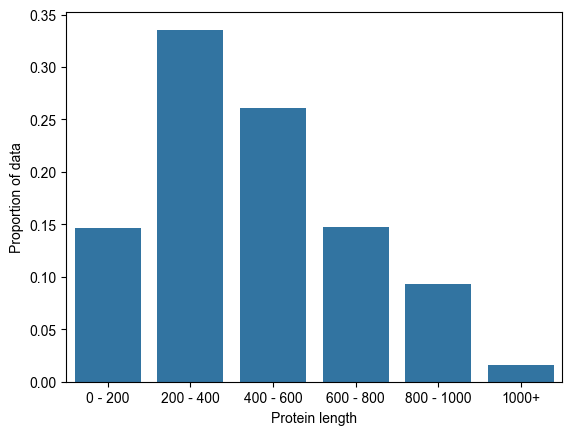

In [34]:
import seaborn as sn

y = [f"{hist[1][i]} - {hist[1][i + 1]}" for i in range(len(hist[1]) - 1)]
y[-1] = f"{hist[1][-2]}+"
ax = sn.barplot(x=y, y=hist[0] / np.sum(hist[0]))
ax.set(xlabel='Protein length', ylabel='Proportion of data')

In [36]:
annotated_df['length_label'] = np.digitize(annotated_df['length'], brackets)
annotated_df

,preds,labels,relevant_sites,pred_indices,length,length_label
A0A024R4G9,"[0.07911567389965057, 0.910444974899292, 0.045...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[16, 20]","[16, 20, 31, 45, 54, 60, 82, 93]",117,1
A0A087WQP5,"[0.9942323565483093, 0.9796654582023621, 0.977...","[1.0, 1.0, 1.0]","[98, 102, 107]","[98, 102, 107]",138,1
A0A0R4J0D1,"[7.239303522510454e-05, 0.0005106111639179289,...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[25, 28, 355]","[4, 19, 25, 26, 28, 50, 79, 85, 143, 149, 150,...",363,2
A0PJX2,"[0.9849071502685547, 0.9922882914543152, 0.000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[153, 155]","[13, 20, 53, 57, 59, 65, 78, 84, 89, 92, 101, ...",215,2
A1IGU4,"[0.5324029326438904, 0.003423320595175028, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[201],"[10, 11, 13, 15, 23, 27, 44, 54, 58, 73, 82, 8...",676,4
...,...,...,...,...,...,...
XP_228801,"[0.03142569586634636, 0.00014448192087002099, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[249, 250, 259]","[18, 25, 35, 42, 52, 59, 69, 76, 86, 93, 98, 1...",513,3
XP_357051,"[0.0002774195745587349, 0.0023367460817098618,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[197],"[3, 5, 32, 33, 53, 70, 71, 99, 118, 119, 132, ...",976,5
XP_574346,"[2.938601392088458e-05, 0.00029009860008955, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[276, 281]","[36, 41, 44, 80, 85, 87, 88, 103, 109, 142, 14...",463,3
XP_575592,"[5.0942857342306525e-05, 0.0001765171036822721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[330, 346, 347, 421]","[10, 34, 61, 66, 82, 93, 94, 95, 106, 118, 127...",513,3


In [45]:
from functools import partial

def gather_fn(vals, buffer):
    buffer.extend(vals)


results = {label : {} for label in annotated_df['length_label'].unique()}
# Calculate metrics for every length label
for label in annotated_df['length_label'].unique():
    data = annotated_df[['preds', 'labels']][annotated_df['length_label'] == label]

    # Extract predictions and labels into a single list, to be processed by metrics
    preds = []
    labels = []
    data['preds'].apply(partial(gather_fn, buffer=preds))
    data['labels'].apply(partial(gather_fn, buffer=labels))

    labels = np.asarray(labels, np.int8)
    binary_preds = (np.asarray(preds) > 0.5).astype(np.int8)

    # Calculate metrics
    metrics = f1_score, precision_score, recall_score, average_precision_score, matthews_corrcoef, roc_auc_score
    names = ['f1', 'precision', 'recall', 'auprc', 'mcc', 'auroc']
    for metric, name in zip(metrics, names):
        try:
            results[label][name] = metric(labels, preds)
        except ValueError:
            results[label][name] = metric(labels, binary_preds)

results

{1: {'f1': 0.3327556325823224,
  'precision': 0.4201312910284464,
  'recall': 0.27546628407460544,
  'auprc': 0.32908988421736723,
  'mcc': 0.23182156810687712,
  'auroc': 0.6675410771977704},
 2: {'f1': 0.26685393258426965,
  'precision': 0.3815261044176707,
  'recall': 0.20518358531317496,
  'auprc': 0.2690127807046394,
  'mcc': 0.20680807052152644,
  'auroc': 0.669488407421927},
 4: {'f1': 0.26554621848739496,
  'precision': 0.42702702702702705,
  'recall': 0.1926829268292683,
  'auprc': 0.3020144638565666,
  'mcc': 0.22216852336362725,
  'auroc': 0.7093168818520799},
 3: {'f1': 0.2704761904761905,
  'precision': 0.3969252271139064,
  'recall': 0.20512820512820512,
  'auprc': 0.27699992182707817,
  'mcc': 0.22169596721765653,
  'auroc': 0.7007078101343638},
 5: {'f1': 0.2717010509926041,
  'precision': 0.40866510538641687,
  'recall': 0.20349854227405248,
  'auprc': 0.28714097294825264,
  'mcc': 0.23425347414781642,
  'auroc': 0.7355259981294179},
 6: {'f1': 0.16591928251121077,
  '

In [46]:
data = annotated_df[['preds', 'labels']]

# Extract predictions and labels into a single list, to be processed by metrics
preds = []
labels = []
data['preds'].apply(partial(gather_fn, buffer=preds))
data['labels'].apply(partial(gather_fn, buffer=labels))

labels = np.asarray(labels, np.int8)
binary_preds = (np.asarray(preds) > 0.5).astype(np.int8)

# Calculate metrics
metrics = f1_score, precision_score, recall_score, average_precision_score, matthews_corrcoef, roc_auc_score
names = ['f1', 'precision', 'recall', 'auprc', 'mcc', 'auroc']
for metric, name in zip(metrics, names):
    try:
        print(f'{name} : {metric(labels, preds)}') 
    except ValueError:
        print(f'{name} : {metric(labels, binary_preds)}')

f1 : 0.27034002193689916
precision : 0.40157178455050796
recall : 0.2037541334370745
auprc : 0.2818945525281186
mcc : 0.22033713267834326
auroc : 0.6992562152179566


In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

for prot in annotated.keys():
    length = len(prot_info.loc[prot]['sequence'])


NameError: name 'annotated' is not defined

In [2]:
import torch
import sys
sys.path.append('../')
sys.path.append('../model')


In [4]:
from classifiers import EncoderClassifier, EncoderClassifierConfig
from training import run_training
from encoder import create_model, add_arguments
from esm_train import get_esm, device, parser
from data_loading import prepare_datasets
from training import LightningWrapper
from torchmetrics import F1Score, MatthewsCorrCoef, Precision, Recall, AUROC, \
MeanMetric, AveragePrecision, PrecisionRecallCurve, MetricCollection
from torch.utils.data import DataLoader
from functools import partial
from data_loading import prep_batch

In [5]:
chkpt_path = '../model/new_logs/encoder_S_60_focal/fold_0/chkpt.ckpt'
checkpoint = torch.load(chkpt_path)

In [13]:
args = parser.parse_args(args=[])

for k, v in checkpoint['hyper_parameters'].items():
    args.__setattr__(k, v)
args.batch_size=16
args

Namespace(seed=42, batch_size=16, epochs=20, prot_info_path='../data/phosphosite_sequences/phosphosite_df.json', dataset_path='../data/splits_S.json', weight_decay=0.0001, accum=2, hidden_size=128, lr=3e-05, o='encoder_S_60_focal', n='esm', compile=False, lora=False, dropout=0.5, type='35M', pos_weight=0.6, num_workers=15, n_layers=1, checkpoint_path=None, model_path=None, focal=False, residues="['S']", ignore_label=-1, patience=15, debug=False, n_layers_mlp=3, block_size=1, cnn_type='basic', expand_m=4, sr_n=3, sr_kernel_size=3, sr_init_size=256, sr_final_size=256, res_kernel_size=31, sr_type='cnn', encoder_dim=256, ffw_dim=2048, expand=4, logdir='new_logs/encoder_S_60_focal')

In [18]:
model, tokenizer = create_model(args)
model = LightningWrapper(args, model, step_metrics=step_metrics, epoch_metrics=epoch_metrics, ds_size=len(train), logdir='.')
model.load_state_dict(checkpoint['state_dict'])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

<All keys matched successfully>

In [15]:
full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)

step_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
})

epoch_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
    'auroc' : AUROC('binary', ignore_index=args.ignore_label),
    'auprc' : AveragePrecision('binary', ignore_index=args.ignore_label),
    'mcc' : MatthewsCorrCoef('binary', ignore_index=args.ignore_label)
})

train_ds, dev_ds, test_ds = full_dataset.get_fold(0)

train = DataLoader(train_ds, args.batch_size, shuffle=True,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False, 
                    num_workers=args.num_workers )
dev = DataLoader(dev_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

Train size: 7180
Dev size: 1796
Test size: 2244


In [12]:
import lightning as L
trainer = L.Trainer()
model.logdir = '.'
trainer.test(model, test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-a499a47b-6eca-00c0-ef67-07b64dce9e09]


Testing DataLoader 0:   0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Testing DataLoader 0: 100%|██████████| 141/141 [00:38<00:00,  3.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_auprc         │    0.6935030221939087     │
│        test_auroc         │    0.8387981653213501     │
│          test_f1          │    0.5957019329071045     │
│         test_loss         │    0.3552580177783966     │
│      test_loss_mean       │    0.3552580177783966     │
│         test_mcc          │    0.5560073256492615     │
│      test_precision       │    0.7883375883102417     │
│        test_recall        │    0.4787227511405945     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3552580177783966,
  'test_loss_mean': 0.3552580177783966,
  'test_f1': 0.5957019329071045,
  'test_precision': 0.7883375883102417,
  'test_recall': 0.4787227511405945,
  'test_auprc': 0.6935030221939087,
  'test_auroc': 0.8387981653213501,
  'test_mcc': 0.5560073256492615}]

In [19]:
model = model.classifier

In [24]:
model.to(model.device)

EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

In [42]:
preds = []
labels = []

with torch.no_grad():
    for batch in test:
        loss, batch_preds = model.predict(**batch.to(model.device))
        batch_labels = batch['labels']
        mask = batch_labels != model.ignore_index
        preds.extend(batch_preds[mask])
        labels.extend(batch_labels[mask])
        

In [43]:
preds = torch.Tensor(preds)
labels = torch.Tensor(labels)

In [44]:
preds = torch.sigmoid(preds)

In [45]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

labels = np.asarray(labels.cpu().numpy(), np.int8)
preds = preds.cpu().numpy()
binary_preds = (np.asarray(preds) > 0.5).astype(np.int8)

In [48]:
# Calculate metrics
metrics = f1_score, precision_score, recall_score, average_precision_score
names = ['f1', 'precision', 'recall', 'auprc', 'mcc', 'auroc']
for metric, name in zip(metrics, names):
    try:
        print(f'{name} : {metric(labels, preds)}') 
    except ValueError:
        print(f'{name} : {metric(labels, binary_preds)}')

f1 : 0.5957019171304886
precision : 0.7883375959079284
recall : 0.4787227433683295
auprc : 0.693503065007329


The metric results are the same as Lighthning test metrics -- they are set up correctly. However, the saved predictions might have some errors... or they are collated erroneously in `pred_analysis.py`. Also, the metadata.json contains test results for the last epoch model. However, the checkpoint is the best model during training w.r.t. F1, so that is why the metrics are mismatched.